# IAU Project - Classification

**Authors:** Peter Mačinec, Lukáš Janík

## Setup and import libraries

At first, we need to import libraries and our pipeline classes from preprocessing:

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce

from sklearn import model_selection as ms

# pipelines
from sklearn.pipeline import Pipeline

# custom pipelines
import pipelines
from pipelines import MergeRemoveDuplicates
from pipelines import DropRowsNanColumn
from pipelines import NanUnifier
from pipelines import BooleanUnifier
from pipelines import WordsUnifier
from pipelines import DateFormatUnifier
from pipelines import ClassUnifier
from pipelines import DropColumn
from pipelines import ColumnExpander
from pipelines import ColumnToNumber
from pipelines import MeasuredValuesFixer
from pipelines import Normalizer
from pipelines import OutliersRemover
from pipelines import OutliersReplacer
from pipelines import NumMedianFiller
from pipelines import NumModelFiller
from pipelines import CategoricalMostFrequentFiller
from pipelines import CategoricalModelFiller
from pipelines import ColumnsSelector
from pipelines import ColumnsEncoder

# hiding warnings for better appereance (this was added after checking all warnings)
import warnings
warnings.filterwarnings(action='ignore')

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

# model evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# decision tree rules diagram
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

# oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE

pd.options.mode.chained_assignment = None  # default='warn'

## Data loading

At first, we need to load all datasets. *Train* and *valid* datasets will be used for training and evaluating model, *test* dataset will be just predicted.

In [2]:
# read datasets
df1_train = pd.read_csv('data/personal_train.csv', index_col=0)
df2_train = pd.read_csv('data/other_train.csv', index_col=0)

df1_test = pd.read_csv('data/personal_test.csv', index_col=0)
df2_test = pd.read_csv('data/other_test.csv', index_col=0)

df1_valid = pd.read_csv('data/personal_valid.csv', index_col=0)
df2_valid = pd.read_csv('data/other_valid.csv', index_col=0)

### Merge datasets

We need to merge both datasets into one following order rule - the order of rows in *personal* dataframe has to be observed. In previous analysis, we found that *name* and *address* would be used for merging:

In [3]:
def merge_remove_duplicates(df1, df2, on=[]):
    return pd.merge(df1, df2.groupby(on).apply(lambda x: x.ffill().bfill()).drop_duplicates(), on=on)

In [4]:
df_train_raw = merge_remove_duplicates(df1_train, df2_train, on=["name", "address"])
df_test_raw = merge_remove_duplicates(df1_test, df2_test, on=["name", "address"])
df_valid_raw = merge_remove_duplicates(df1_valid, df2_valid, on=["name", "address"])

## Preprocessing

Before data will be used for classification, we have to preprocess it. Custom classes for preprocessing pipeline were imported from *pipelines.py* file.

Because only *train* and *valid* datasets contain *class* attribute, *ClassUnifier* will be applied separately. Let's create both pipelines:

In [5]:
ppl = Pipeline([
                # Data repairing
                # ======================
                # unify boolean values
                ('unify_boolean', BooleanUnifier(['query hyperthyroid', 'T4U measured', 'on thyroxine', 'FTI measured', 'lithium', 'TT4 measured',
                                                  'query hypothyroid', 'query on thyroxine', 'tumor', 'T3 measured', 'sick', 'thyroid surgery', 
                                                  'I131 treatment', 'goitre', 'TSH measured', 'on antithyroid medication', 'psych', 'TBG measured',
                                                  'pregnant', 'hypopituitary'])),

                # unify date format
                ('date_unifier', DateFormatUnifier('date_of_birth')),

                # drop column
                ('drop_TBG_measured', DropColumn('TBG measured')),
                ('drop_TBG', DropColumn('TBG')),

                # measured columns fix
                ('fix_measured_values',MeasuredValuesFixer(['T4U', 'FTI', 'TT4', 'TT4','TSH','T3'])),

                # expand column
                ('expand_personal_info', ColumnExpander()),

                # unify nan values
                ('nan_unify_FTI', NanUnifier(['FTI', 'sex', 'origin', 'occupation'])),

                # transform data type
                ('column_to_number_FTI', ColumnToNumber('FTI')),

                # ======================

                # Data normalization
                # ======================
                ('norm_numerical', Normalizer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Outliers replacement
                # ======================
                ('reout_numerical', OutliersReplacer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Filling numerical values by Linear Regression
                # ======================
                ('flr_T4U', NumModelFiller('T4U', LinearRegression())),
                ('flr_TT4', NumModelFiller('TT4', LinearRegression())),
                ('flr_T3', NumModelFiller('T3', LinearRegression())),
                ('flr_TSH', NumModelFiller('TSH', LinearRegression())),
                ('flr_FTI', NumModelFiller('FTI', LinearRegression())),
                ('flr_age', NumModelFiller('age', LinearRegression())),
                ('flr_education_num', NumModelFiller('education-num', LinearRegression())),
                ('flr_fnlwgt', NumModelFiller('fnlwgt', LinearRegression())),
                ('flr_capital_loss', NumModelFiller('capital-loss', LinearRegression())),
                ('flr_capital_gain', NumModelFiller('capital-gain', LinearRegression())),
                ('flr_hours_per_week', NumModelFiller('hours-per-week', LinearRegression())),
                # ======================

                # Filling categorical values by RF
                # ======================
                ('fill_rf_sex', CategoricalModelFiller('sex', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_pregnant', CategoricalModelFiller('pregnant', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_tumor', CategoricalModelFiller('tumor', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_occupation', CategoricalModelFiller('occupation', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_origin', CategoricalModelFiller('origin', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_query_hypothyroid', CategoricalModelFiller('query hypothyroid', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_query_hyperthyroid', CategoricalModelFiller('query hyperthyroid', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_on_thyroxine', CategoricalModelFiller('on thyroxine', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_sick', CategoricalModelFiller('sick', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_thyroid_surgery', CategoricalModelFiller('thyroid surgery', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_workclass', CategoricalModelFiller('workclass', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_I131_treatment', CategoricalModelFiller('I131 treatment', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_hypopituitary', CategoricalModelFiller('hypopituitary', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_query_on_thyroxine', CategoricalModelFiller('query on thyroxine', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_on_antithyroid_medication', CategoricalModelFiller('on antithyroid medication', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_referral_source', CategoricalModelFiller('referral source', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_psych', CategoricalModelFiller('psych', RandomForestClassifier(n_estimators=100, max_depth=7))),
                
                # Filling categorical with most frequent value
                # ======================
                ('fill_mf_date_of_birth', CategoricalMostFrequentFiller(['date_of_birth'])),
                ('fill_mf_study', CategoricalMostFrequentFiller(['study'])),
                ('fill_mf_status1', CategoricalMostFrequentFiller(['status1'])),
                ('fill_mf_status2', CategoricalMostFrequentFiller(['status2']))
              ])

ppl_class_unifier = Pipeline([
        ('class_unifier', ClassUnifier())
    ])

Created pipelines can be now used to preprocess our data. Pipeline with *ClassUnifier* will not be applied to *test* dataframe as mentioned before. 

In [6]:
df_train = ppl.fit_transform(df_train_raw)
df_valid = ppl.transform(df_valid_raw)

df_train = ppl_class_unifier.fit_transform(df_train)
df_valid = ppl_class_unifier.transform(df_valid)

df_test = ppl.transform(df_test_raw)

Score for column T4U: -0.00376015380089442
Score for column TT4: -0.0044668429893978435
Score for column T3: -0.07919221538796
Score for column TSH: -1.875364426297588
Score for column FTI: -0.0037999347889374536
Score for column age: -0.16674494625564273
Score for column education-num: -0.6837425642570153
Score for column fnlwgt: -10981116919.264507
Score for column capital-loss: -133615.96406947292
Score for column capital-gain: -62593728.38294051
Score for column hours-per-week: -145.20317310705107
Score for column sex: 0.7133480644304377
Score for column pregnant: 0.9875367163982725
Score for column tumor: 0.9758685137732224
Score for column occupation: 0.2872630983261446
Score for column origin: 0.913027184835275
Score for column query hypothyroid: 0.9409968592070609
Score for column query hyperthyroid: 0.9392093921275535
Score for column on thyroxine: 0.8802095077941491
Score for column sick: 0.9611126681614349
Score for column thyroid surgery: 0.9861446277315112
Score for column

Our dataframes are now preprocessed. We can check scores for predictions of filling values.

Let's check how data look like after preprocessing:

In [7]:
df_train.head()

,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,TT4,...,education-num,psych,occupation,pregnant,bred,origin,study,status1,status2,class_status
0,Terry Terry,"11818 Lori Crossing Apt. 802\r\nPughstad, DC 7...",4.143135,M,12/09/1955,False,False,False,False,4.418841,...,2.197225,False,Transport-moving,False,white,united-states,hs-grad,divorced,unmarried,negative
1,Edith Boudreaux,"PSC 4657, Box 5446\r\nAPO AP 58412",4.290459,F,30/04/1945,False,True,True,False,4.787492,...,2.426560,False,Prof-specialty,False,white,united-states,bachelors,never-married,own-child,negative
2,Janet Washington,Unit 9759 Box 9470\r\nDPO AP 45549,4.304065,F,06/06/1944,False,True,True,False,4.727388,...,2.510752,False,Craft-repair,False,white,united-states,hs_grad,divorced,unmarried,negative
3,Margaret Chabot,"137 Lewis Flat Suite 762\r\nWest Elizabeth, AL...",3.891820,F,01/10/1969,False,True,True,False,5.209486,...,2.302585,False,Adm-clerical,False,white,united-states,some-college,divorced,unmarried,negative
4,Colleen Satterwhite,"995 Frank Stravenue\r\nSouth Matthewport, TX 8...",2.995732,F,08/01/2016,False,True,True,False,4.976734,...,2.197225,False,Other-service,False,black,united-states,hs-grad,never-married,unmarried,negative


Similarly, valid and test datasets have been preprocessed.

## Choosing columns and encoding values

Last step before data are ready for classification is to choose columns and encode categorical values. For this purpose, OneHotEncoding will be used. 

Saving our labels into separate variables is important for fitting classifiers:

In [8]:
y_train = df_train['class_status']
y_test = df_valid['class_status']

Let's select columns and encode categorical attributes. Firstly, we will try our choice of attributes based on previous data analysis:

In [9]:
ppl_select_encode = Pipeline([
                        ('col_select', ColumnsSelector(['T4U', 'TT4', 'TSH', 'T3', 'FTI', 'sex', 'pregnant'])),
                        ('cat_encode', ColumnsEncoder(['sex', 'pregnant']))
                    ])

In [10]:
X_train = ppl_select_encode.fit_transform(df_train)
X_test = ppl_select_encode.transform(df_valid)
X_test_final = ppl_select_encode.transform(df_test)

Because our data is heavily unbalanced, we will try **oversampling**. We will try 2 methods of oversampling - *random* and *SMOTE* from imbalanced learn library (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html).

In [11]:
X_res_rand, y_res_rand = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
X_res_smote, y_res_smote = SMOTE(random_state=0).fit_resample(X_train, y_train)

## Classification

At this section, we will try to classify **class**, that indicates whether patient is ill or not. We will use selection of  preprocessed data.

### Classification rules

At first, we will try to choose classification rules manually, based on previous analysis. For recapitulation, let's check plots of hormones values distributions:

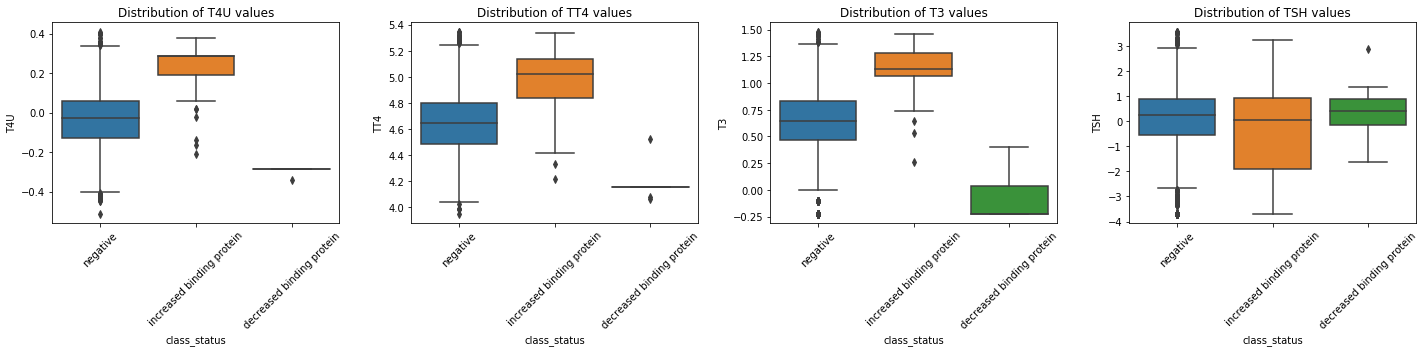

In [12]:
plt.rcParams['figure.figsize'] = (20, 5)

# Subplot of T4U hormone
plt.subplot(1, 4, 1)
sns.boxplot('class_status','T4U', data=df_train)
plt.title('Distribution of T4U values')
plt.xticks(rotation=45)

# Subplot of TT4 hormone
plt.subplot(1, 4, 2)
sns.boxplot('class_status','TT4', data=df_train)
plt.title('Distribution of TT4 values')
plt.xticks(rotation=45)

# Subplot of T3 hormone
plt.subplot(1, 4, 3)
sns.boxplot('class_status','T3', data=df_train)
plt.title('Distribution of T3 values')
plt.xticks(rotation=45)

# Subplot of TSH hormone
plt.subplot(1, 4, 4)
sns.boxplot('class_status','TSH', data=df_train)
plt.title('Distribution of TSH values')
plt.xticks(rotation=45)

plt.tight_layout()

Those attributes (hormones) have been identified as useful for prediction.

We will create **3 classifiers** using manually created rules:
- two classifiers working with T4U and T3 values  
- third classifier which is closer to usual sklearn classifier

#### Manual classifier working with **T4U** values

In [13]:
# T4U Negative
T4U_N_Q1 = -0.12783337150988489
T4U_N_Q3 = 0.058268908123975824

# T4U increased binding protein
T4U_I_Q1 = 0.1906203596086497
T4U_I_Q3 = 0.28517894223366247

# T4U decreased binding protein
T4U_D_Q1 = -0.2876820724517809
T4U_D_Q3 = -0.2876820724517809

unique_class_status = y_train.unique()

def predict_T4U(df):
    predictions = []
    for index, row in df.iterrows():
        scores = [0,0,0]

        max_ = 0
        max_counter = 0
        index = 0
        
        value = float(row['T4U'])
        
        if (value >= T4U_N_Q1 and value <= T4U_N_Q3):
            scores[0] += 1
        if (value >= T4U_I_Q1 and value <= T4U_I_Q3):
            scores[1] += 2
        if (value >= T4U_D_Q1 and value <= T4U_D_Q3):
            scores[2] += 2

        for i in range(0,3):
            if (scores[i] > max_):
                max_ = scores[i]
                max_counter = 0
                index = i
            elif (scores[i] == max_):
                max_counter += 1
                
        predictions.append(unique_class_status[index])

    return predictions

#### Manual classifier working with **T3** values

In [14]:
# T3 Negative
T3_N_Q1 = 0.47000362924573563
T3_N_Q3 = 0.8317367937769585

# T3 increased binding protein
T3_I_Q1 = 1.0647107369924282
T3_I_Q3 = 1.2809338454620642

# T3 decreased binding protein
T3_D_Q1 = -0.2231435513142097
T3_D_Q3 = 0.03408335643289209

unique_class_status = y_train.unique()

def predict_T3(df):
    predictions = []

    for index, row in df.iterrows():
        scores = [0,0,0]

        max_ = 0
        max_counter = 0
        index = 0

        value = float(row['T3'])

        if (value >= T3_N_Q1 and value <= T3_N_Q3):
            scores[0] += 1

        if (value >= T3_I_Q1 and value <= T3_I_Q3):
            scores[1] += 1

        if (value >= T3_D_Q1 and value <= T3_D_Q3):
            scores[2] += 1

        for i in range(0,3):
            if (scores[i] > max_):
                max_ = scores[i]
                max_counter = 0
                index = i
            elif (scores[i] == max_):
                max_counter += 1

        predictions.append(unique_class_status[index])

    return predictions

Let's try to make predictions with these classifiers and see the results:

In [15]:
pred_T4U_test = predict_T4U(X_test)
pred_T3_test = predict_T3(X_test)

The results aren't as good as we could've expected. However, at least the **classifier** working with **T4U** values isn't that bad: 

In [16]:
print('T4U\n' + classification_report(y_test, pred_T4U_test))
print('T3\n' + classification_report(y_test, pred_T3_test))

T4U
                           precision    recall  f1-score   support

decreased binding protein       0.18      1.00      0.30         5
increased binding protein       0.25      0.72      0.38        25
                 negative       0.99      0.92      0.95       942

                micro avg       0.91      0.91      0.91       972
                macro avg       0.47      0.88      0.54       972
             weighted avg       0.97      0.91      0.94       972

T3
                           precision    recall  f1-score   support

decreased binding protein       0.04      0.60      0.07         5
increased binding protein       0.26      0.56      0.36        25
                 negative       0.98      0.88      0.93       942

                micro avg       0.87      0.87      0.87       972
                macro avg       0.43      0.68      0.45       972
             weighted avg       0.96      0.87      0.91       972



Let's implement the 3rd manual classifier but this time in a more sofisticated way. It is implemented as usual sklearn classifier, so fit and predict methods are available. The classifier uses only numerical attributes and the rules which were previously manually defined. It automatically gets boundary values for each attribute by fitting the data. According to boundaries a score is assigned. In the end it allows to make decision (prediction) which class it is supposed to be.

In [17]:
class ManualRulesClassifier():
    def __init__(self):
        pass
    
    def get_ranges(self, columns, label):
        self.columns_class_ranges = {}
        for column in columns:
            class_ranges = []
            for class_ in self.unique_class_status:
                Q1 = self.train[label == class_][column].quantile(.25)
                Q2 = self.train[label == class_][column].quantile(.50)
                Q3 = self.train[label == class_][column].quantile(.75)
                class_ranges.append([Q1,Q2,Q3])
            self.columns_class_ranges[column] = class_ranges
   
    def get_prediction(self, row):
        scores = [0,0,0]
        for key, value in self.columns_class_ranges.items():
            value = row[key]
            for i in range(0,3):
                Q1 = self.columns_class_ranges[key][i][0]
                Q2 = self.columns_class_ranges[key][i][1]
                Q3 = self.columns_class_ranges[key][i][2]
                
                lower_boundary = Q1 - (Q3 - Q1) * 1.5
                upper_boundary = Q3 + (Q3 - Q1) * 1.5

                if (value >= Q1 and value <= Q3):
                    scores[i] += 2
                elif ((value < Q1 and value >= lower_boundary) or (value > Q3 and value <= upper_boundary)):
                    scores[i] += 1
                elif (value == Q2):
                    scores[i] += 3
                
        max_ = 0
        max_counter = 0
        index = 0
        
        for i in range(0,3):
            if (scores[i] > max_):
                max_ = scores[i]
                max_counter = 0
                index = i
            elif (scores[i] == max_):
                max_counter += 1
        
        return self.unique_class_status[index]
    
    def fit(self, df_train, y_train):
        self.train = df_train
        self.unique_class_status = y_train.unique()
        self.get_ranges(['T4U', 'T3', 'TT4', 'TSH'], y_train)

    def predict(self, df_test):
        predictions = []
        for index, row in df_test.iterrows():
            predictions.append(self.get_prediction(row))
        return predictions

Now let's create classifier, fit the data and predict values:

In [18]:
manual_rules_clf = ManualRulesClassifier()

In [19]:
manual_rules_clf.fit(X_train, y_train)
y_pred = manual_rules_clf.predict(X_test)

Records are predicted, check the accuracy score:

In [20]:
accuracy_score(y_test, y_pred)

0.8816872427983539

Accuracy score is not bad in this case, but because of heavily unbalanced data this score is not representative enough. Let's check a different table with scores:

In [21]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.13      0.80      0.23         5
increased binding protein       0.19      0.80      0.31        25
                 negative       0.99      0.88      0.94       942

                micro avg       0.88      0.88      0.88       972
                macro avg       0.44      0.83      0.49       972
             weighted avg       0.97      0.88      0.92       972



We've tested the 3rd classifier with various numerical attributes. We've gained even better scores than the one displayed in the table above (using T3). The problem was that even though the overall scores were higher, the scores looking at particular classes were not so satisfying. Therefore we've decided to add TSH attribute to improve these scores even though the overall scores got slightly worse.

### DecisionTree

As decision tree is based on finding rules, it seems to be a proper choice to compare with our manual rules based classifier. Parameters were chosen intuitively, but will be tuned later. Also we run *class_weight*='balanced' because of unbalanced classes.

In [22]:
dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=0)

In [23]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [24]:
y_pred = dt.predict(X_test)

Evaluating the prediction by accuracy:

In [25]:
accuracy_score(y_test, y_pred)

0.9650205761316872

Other metrics for evaluating the prediction are displayed in table below:

In [26]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.67      0.80      0.73         5
increased binding protein       0.43      0.72      0.54        25
                 negative       0.99      0.97      0.98       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.70      0.83      0.75       972
             weighted avg       0.98      0.97      0.97       972



Other settings for decision tree classifier, this time without *weight_class* = 'balanced' as we try to balance the unbalanced class by *random oversampling*.

#### DecisionTree with random oversampling

In [27]:
dt_2 = DecisionTreeClassifier(max_depth=10, random_state=0)

In [28]:
dt_2.fit(X_res_rand, y_res_rand)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [29]:
y_pred = dt_2.predict(X_test)

Also displaying table with various metrics for evalution of the prediction. The results are just slightly worse than in previous case.

In [30]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.57      0.80      0.67         5
increased binding protein       0.31      0.68      0.43        25
                 negative       0.99      0.96      0.97       942

                micro avg       0.95      0.95      0.95       972
                macro avg       0.63      0.81      0.69       972
             weighted avg       0.97      0.95      0.96       972



#### DecisionTree with SMOTE oversampling

A different approach also using oversampling but this time with method called *smote*.

In [31]:
dt_2.fit(X_res_smote, y_res_smote)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [32]:
y_pred = dt_2.predict(X_test)

Other metrics for evaluating the prediction are displayed in table below. There are lots of differences but let's consider the *f1-score* macro avg as the main score. The average *f1-score* is lower than in the random oversampling used previously.

In [33]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.33      0.80      0.47         5
increased binding protein       0.25      0.80      0.38        25
                 negative       0.99      0.93      0.96       942

                micro avg       0.92      0.92      0.92       972
                macro avg       0.53      0.84      0.61       972
             weighted avg       0.97      0.92      0.94       972



Let's visualize the tree graph of decision tree classifier rules.

**Note:** Image can be large when displayed. In this case, it can be opened in browser new tab or downloaded.

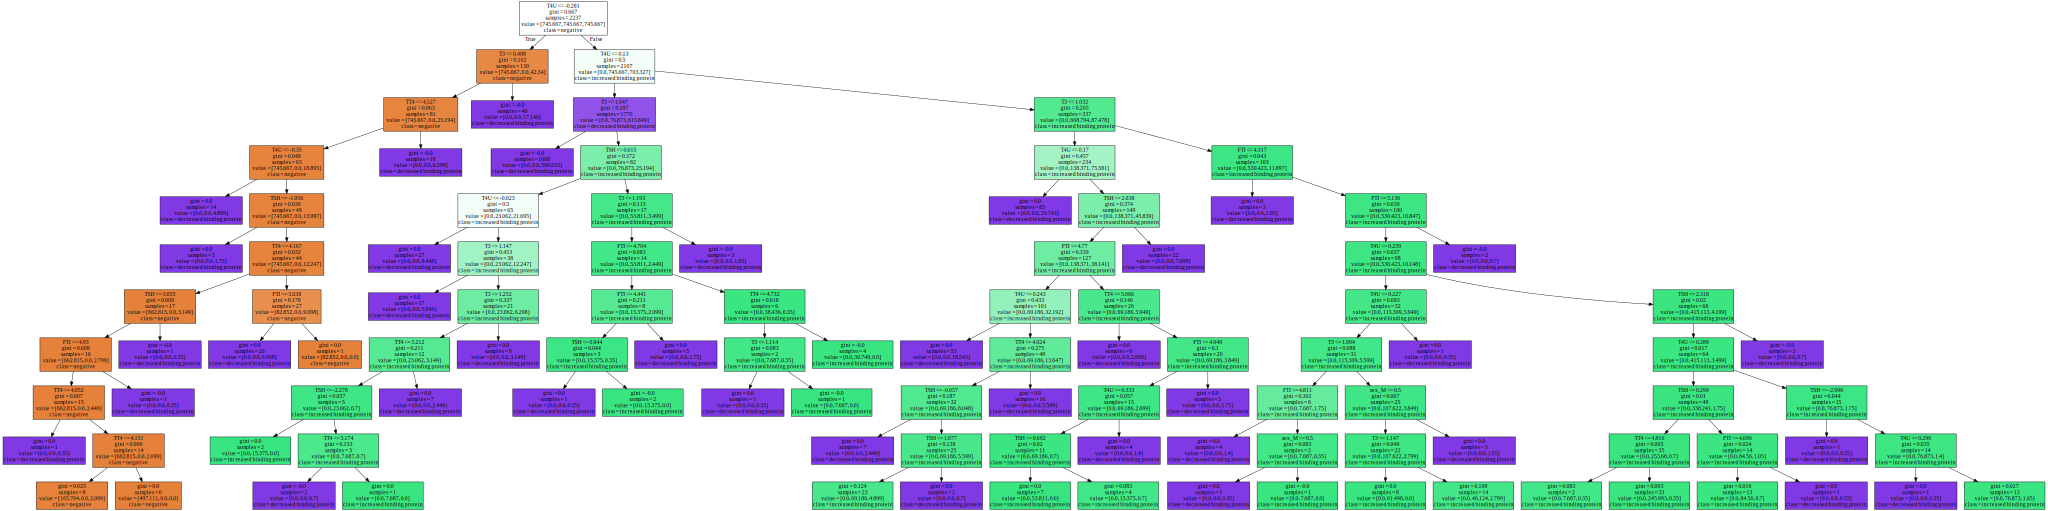

In [34]:
graph = Source(tree.export_graphviz(dt, out_file=None
   , feature_names=X_train.columns, class_names=y_train.unique() 
   , filled = True))

display(SVG(graph.pipe(format='svg')))

Let's find the importance of each attribute we've selected for this decision tree:

In [35]:
pd.DataFrame(dt.feature_importances_, index = X_train.columns,
            columns=['importance']).sort_values('importance', ascending=False)

,importance
T4U,0.811341
T3,0.120956
FTI,0.023690
TT4,0.021554
TSH,0.020656
sex_M,0.001803
sex_F,0.000000
pregnant_False,0.000000
pregnant_True,0.000000


As expected, hormones are the most important features.

### DecisionTree parameter tuning

Let's check the affect of parameters tuning on decision tree classifier.
We've chosen following parameters:
- *max_depth* - the maximum depth of tree, it can heavily affect overfitting which we would like to avoid
- *min_samples_leaf* - the minimum number of samples required to split an internal node
- *max_features* - the number of features to consider when looking for the best split
- *criterion* - function to measure the quality of a split

In [36]:
decision_tree = DecisionTreeClassifier()

In [37]:
param_dist = {"max_depth": [x for x in range(1, 15)], "min_samples_leaf": [x for x in range(1, 6)], "min_samples_split": [x for x in range(2, 6)], "max_features": [x for x in range(1, 10)], "criterion":["gini","entropy"]}

#### Affect of parameters settings

Let's try the chosen params and their values we've set. We will use the decision tree to make prediction using with each setting and store the accuracy and f1 macro values of predictions we get.

In [38]:
scores_train_acc_1 = []
scores_test_acc_1 = []
scores_train_f1_1 = []
scores_test_f1_1 = []

scores_train_acc_2 = []
scores_test_acc_2 = []
scores_train_f1_2 = []
scores_test_f1_2 = []

scores_train_acc_3 = []
scores_test_acc_3 = []
scores_train_f1_3 = []
scores_test_f1_3 = []

scores_train_acc_4 = []
scores_test_acc_4 = []
scores_train_f1_4 = []
scores_test_f1_4 = []


for i in param_dist["max_depth"]:
    dt_t = DecisionTreeClassifier(max_depth = i)
    dt_t.fit(X_train, y_train)
#     scores_train.append(cross_val_score(dt_t, X_train, y_train, cv=10, scoring='f1_macro'))
#     scores_test.append(cross_val_score(dt_t, X_test, y_test, cv=10, scoring='f1_macro'))
    train_pred = dt_t.predict(X_train)
    test_pred = dt_t.predict(X_test)
    
    scores_train_f1_1.append(f1_score(y_train, train_pred , average='macro'))
    scores_test_f1_1.append(f1_score(y_test, test_pred , average='macro'))

    scores_train_acc_1.append(accuracy_score(y_train, train_pred))
    scores_test_acc_1.append(accuracy_score(y_test, test_pred))
# ============================================================================================

for i in param_dist["min_samples_leaf"]:
    dt_t = DecisionTreeClassifier(min_samples_leaf = i)
    dt_t.fit(X_train, y_train)
    train_pred = dt_t.predict(X_train)
    test_pred = dt_t.predict(X_test)
    
    scores_train_f1_2.append(f1_score(y_train, train_pred , average='macro'))
    scores_test_f1_2.append(f1_score(y_test, test_pred , average='macro'))

    scores_train_acc_2.append(accuracy_score(y_train, train_pred))
    scores_test_acc_2.append(accuracy_score(y_test, test_pred))
# ============================================================================================

for i in param_dist["max_features"]:
    dt_t = DecisionTreeClassifier(max_features = i)
    dt_t.fit(X_train, y_train)
    train_pred = dt_t.predict(X_train)
    test_pred = dt_t.predict(X_test)
    
    scores_train_f1_3.append(f1_score(y_train, train_pred , average='macro'))
    scores_test_f1_3.append(f1_score(y_test, test_pred , average='macro'))

    scores_train_acc_3.append(accuracy_score(y_train, train_pred))
    scores_test_acc_3.append(accuracy_score(y_test, test_pred))
# ============================================================================================

for i in param_dist["min_samples_split"]:
    dt_t = DecisionTreeClassifier(min_samples_split = i)
    dt_t.fit(X_train, y_train)
    train_pred = dt_t.predict(X_train)
    test_pred = dt_t.predict(X_test)
    
    scores_train_f1_4.append(f1_score(y_train, train_pred , average='macro'))
    scores_test_f1_4.append(f1_score(y_test, test_pred , average='macro'))

    scores_train_acc_4.append(accuracy_score(y_train, train_pred))
    scores_test_acc_4.append(accuracy_score(y_test, test_pred))

##### Affect of max_depth
We can see that *max_depth* heavily affects overfitting. The training score keeps raising almost constantly regardless of the currently set *max_depth*. However, as the *max_depth* reaches value of 2 or higher, we can see that previously highly growing test score either starts to grow slower or drops rapidly.

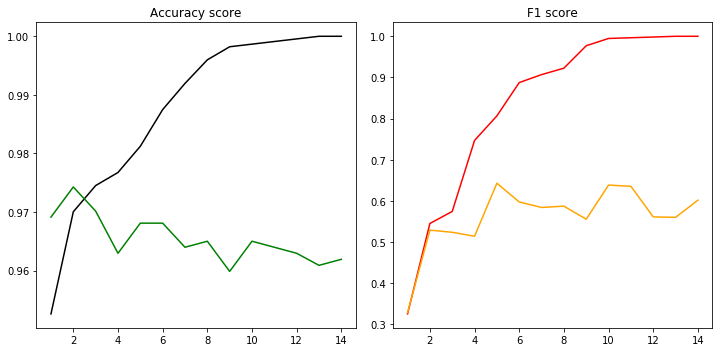

In [39]:
plt.rcParams['figure.figsize'] = (20, 5)

plt.subplot(1, 4, 1)
plt.plot(param_dist['max_depth'],scores_train_acc_1, color='black')
plt.plot(param_dist['max_depth'],scores_test_acc_1, color='green')
plt.title('Accuracy score')

plt.subplot(1, 4, 2)
plt.plot(param_dist['max_depth'],scores_train_f1_1, color='red')
plt.plot(param_dist['max_depth'],scores_test_f1_1, color='orange')
plt.title('F1 score')

plt.tight_layout()

##### Affect of min_samples_leaf
We can see that min_samples_leaf affects both the score for train and test. The higher the value of min_samples_leaf the lower the score for train. The score for test is neither growing or descending with several local mins and maxs.

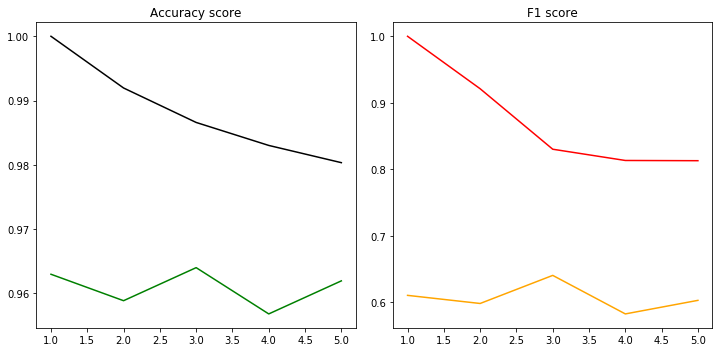

In [40]:
plt.subplot(1, 4, 1)
plt.plot(param_dist['min_samples_leaf'],scores_train_acc_2, color='black')
plt.plot(param_dist['min_samples_leaf'],scores_test_acc_2, color='green')
plt.title('Accuracy score')

plt.subplot(1, 4, 2)
plt.plot(param_dist['min_samples_leaf'],scores_train_f1_2, color='red')
plt.plot(param_dist['min_samples_leaf'],scores_test_f1_2, color='orange')
plt.title('F1 score')

plt.tight_layout()

##### Affect of max_features
We can see that the value of max_features doesn't affect score for train. The score for test looks like a roler coaster with higher tendency to descend.

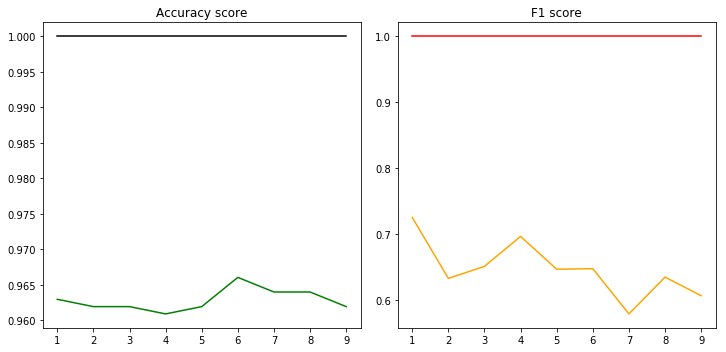

In [41]:
plt.rcParams['figure.figsize'] = (20, 5)

plt.subplot(1, 4, 1)
plt.plot(param_dist['max_features'],scores_train_acc_3, color='black')
plt.plot(param_dist['max_features'],scores_test_acc_3, color='green')
plt.title('Accuracy score')

plt.subplot(1, 4, 2)
plt.plot(param_dist['max_features'],scores_train_f1_3, color='red')
plt.plot(param_dist['max_features'],scores_test_f1_3, color='orange')
plt.title('F1 score')

plt.tight_layout()

##### Affect of min_samples_split
We can see that the value of min_samples_split affects score both for train and test. The train score has mainly tendency to descend. The test score descends as well but from a certain point it starts to grow till the end.

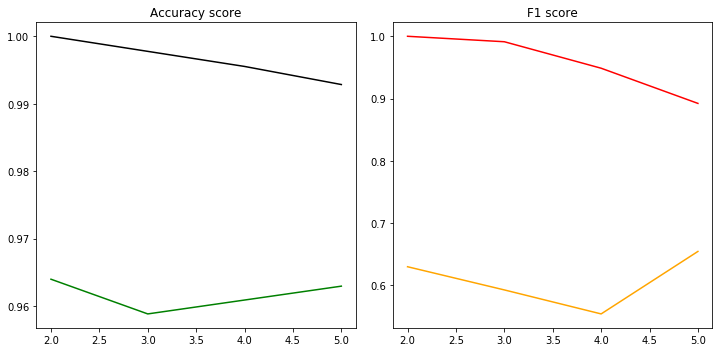

In [42]:
plt.rcParams['figure.figsize'] = (20, 5)

plt.subplot(1, 4, 1)
plt.plot(param_dist['min_samples_split'],scores_train_acc_4, color='black')
plt.plot(param_dist['min_samples_split'],scores_test_acc_4, color='green')
plt.title('Accuracy score')

plt.subplot(1, 4, 2)
plt.plot(param_dist['min_samples_split'],scores_train_f1_4, color='red')
plt.plot(param_dist['min_samples_split'],scores_test_f1_4, color='orange')
plt.title('F1 score')

plt.tight_layout()

Also we have tried combination of those parameters. This can be found below in **Hyperparameter tuning** section.

### RandomForest

As a second classifier we have chosen RandomForest, which is based on multiple DecisionTrees. Parameters will be chosen based on our intuition, but will be tuned later.

In [43]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0, class_weight='balanced')

In [44]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Let's predict values and evaluate how well RandomForest performed:

In [45]:
y_pred = rf.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.9722222222222222
                           precision    recall  f1-score   support

decreased binding protein       1.00      0.20      0.33         5
increased binding protein       0.53      0.64      0.58        25
                 negative       0.99      0.99      0.99       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.84      0.61      0.63       972
             weighted avg       0.97      0.97      0.97       972



F1 macro is slightly worse than in case of DecisionTree. For better comparison, we have to try both oversampling methods with RandomForest.

#### RandomForest with random oversampling

In [46]:
rf.fit(X_res_rand, y_res_rand)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Let's predict values and evaluate how well RandomForest performed:

In [47]:
y_pred = rf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

Accuracy:  0.9670781893004116 

                           precision    recall  f1-score   support

decreased binding protein       1.00      0.40      0.57         5
increased binding protein       0.45      0.68      0.54        25
                 negative       0.99      0.98      0.98       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.81      0.69      0.70       972
             weighted avg       0.97      0.97      0.97       972



As we can see on F1 macro score, random oversampling helped to achieve better model. It is significantly better when using oversampling in comparison with DecisionTree. Let's try also oversampling with smote method.

#### RandomForest with SMOTE oversampling

In [48]:
rf.fit(X_res_smote, y_res_smote)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Let's predict values and evaluate how well RandomForest performed:

In [49]:
y_pred = rf.predict(X_test)

In [50]:
accuracy_score(y_test, y_pred)

0.9423868312757202

In [51]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.30      0.60      0.40         5
increased binding protein       0.33      0.84      0.47        25
                 negative       0.99      0.95      0.97       942

                micro avg       0.94      0.94      0.94       972
                macro avg       0.54      0.80      0.61       972
             weighted avg       0.97      0.94      0.95       972



Using *smote* oversampling method hasn't elevated model performance for neither of classifiers. (DecisionTree, RandomForest)

The best result's been achieved using the dataset balanced by random oversampling method. Suprisingly the worst result's been achieved using *smote* oversampling method.

Let's check the importance of features used by random forest for prediction:

In [52]:
pd.DataFrame(rf.feature_importances_, index = X_train.columns,
            columns=['importance']).sort_values('importance', ascending=False)

,importance
T4U,0.423270
T3,0.305756
TT4,0.156734
TSH,0.035401
FTI,0.030572
sex_M,0.015933
sex_F,0.012256
pregnant_True,0.011948
pregnant_False,0.008129


Again, hormones influenced performance the most.

### XGBoost

XGBoost is known as well performing classifier.

Data needs to be transformed in advance (requirement for XGBoost). Both, train and test datasets have to have the same feature order.

In [53]:
X_res_rand = pd.DataFrame(X_res_rand, columns=X_train.columns)
X_test = X_test.reindex_axis(X_res_rand.columns, axis=1)

Now, let's try XGBoost classifier. Parameters have been chosen manually by trying various configurations:

In [54]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=8, min_child_weight=2, gamma=0.1)

Let's fit, predict values and evaluate how well XGBoost performed:

In [55]:
xgb.fit(X_res_rand, y_res_rand)
y_pred = xgb.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

Accuracy:  0.9681069958847737 

                           precision    recall  f1-score   support

decreased binding protein       0.62      1.00      0.77         5
increased binding protein       0.46      0.72      0.56        25
                 negative       0.99      0.97      0.98       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.69      0.90      0.77       972
             weighted avg       0.98      0.97      0.97       972



Because of previous experience of using random oversampling with RandomForest, we have tried this configuration also for XGBoost. Using XGBoost, the best F1 macro score has been achieved and would be used for predictions.

### Predictions with all attributes

As previous classifications rely on our choice of attributes, we should try all of them because all information can not be spotted on the first view. Just attributes like name or address are left out.

In [56]:
ppl_select_encode_all = Pipeline([
                        ('col_select', ColumnsSelector(['T4U', 'TT4', 'TSH', 'T3', 'FTI', 
                                                        'age', 'origin', 'query hyperthyroid', 
                                                        'lithium', 'capital-loss', 'capital-gain', 
                                                        'query hypothyroid', 'on thyroxine', 
                                                        'tumor', 'fnlwgt', 'hours-per-week', 
                                                        'sick', 'thyroid surgery', 'workclass', 
                                                        'I131 treatment', 'goitre', 'hypopituitary', 
                                                        'query on thyroxine', 'referral source', 
                                                        'on antithyroid medication', 'education-num', 
                                                        'psych', 'occupation', 'bred', 'study', 
                                                        'sex', 'pregnant'])),
                        ('cat_encode', ColumnsEncoder(['origin', 'query hyperthyroid', 'lithium', 
                                                       'query hypothyroid', 'on thyroxine', 'tumor', 
                                                       'sick', 'thyroid surgery', 'workclass', 
                                                       'I131 treatment', 'goitre', 'hypopituitary', 
                                                       'query on thyroxine', 'referral source', 
                                                       'on antithyroid medication', 'psych', 
                                                       'occupation', 'bred', 'study', 'sex', 'pregnant']))
                    ])

Using pipeline, we will choose and encode all columns:

In [57]:
X_train_all = ppl_select_encode_all.fit_transform(df_train)
X_test_all = ppl_select_encode_all.transform(df_valid)

To compare our results, DecisionTree and RandomForest classifiers that have been used before are trained on all attributes:

In [58]:
dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=0)
dt.fit(X_train_all, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Let's predict values and evaluate how well DecisionTree performed:

In [59]:
y_pred = dt.predict(X_test_all)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.9465020576131687
                           precision    recall  f1-score   support

decreased binding protein       0.18      0.40      0.25         5
increased binding protein       0.35      0.72      0.47        25
                 negative       0.99      0.96      0.97       942

                micro avg       0.95      0.95      0.95       972
                macro avg       0.51      0.69      0.57       972
             weighted avg       0.97      0.95      0.96       972



Using all attributes has negative impact on DecisionTree score. This can be caused by using features, that can't help to predict *class* and just degrade model performance.

Let's try also RandomForest.

As RandomForest performs better with oversampled data in our case, we should do oversampling also this time:

In [60]:
X_train_all_res, y_all_res = RandomOverSampler(random_state=0).fit_resample(X_train_all, y_train)

In [61]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0, class_weight='balanced')
rf.fit(X_train_all_res, y_all_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Let's predict values and evaluate how well RandomForest performed:

In [62]:
y_pred = rf.predict(X_test_all)
print("Accuracy: ", accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

Accuracy:  0.9619341563786008 

                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         5
increased binding protein       0.41      0.64      0.50        25
                 negative       0.98      0.98      0.98       942

                micro avg       0.96      0.96      0.96       972
                macro avg       0.47      0.54      0.49       972
             weighted avg       0.97      0.96      0.96       972



As we can see, even in case of RandomForest, using all attributes has negative impact on model performance.

Probably, choosing all attributes is bad choice in general. Classifiers perform significantly better with our first choice of attributes based on analysis, rather than using all of them.

### Feature selection

Feature selection is efective way to reduce number of attributes. We have tried models using all attributes, but probably not all of them are useful for predictions.

How many of attributes have we tried?

In [63]:
len(X_train_all.columns)

128

We will try **Recursive Feature Elimination with Cross-Validation (RFECV)** method to choose best features for predictions. As estimator, RandomForestClassifier from previous sections will be used:

In [64]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0, class_weight='balanced')

Now, let's create feature selector and fit it on our data. As mentioned before, RFECV will be used:

In [65]:
rfecv = RFECV(estimator=rf, step=1, cv=10, scoring='f1_macro')

In [66]:
rfecv.fit(X_train_all_res, y_all_res)

RFECV(cv=10,
   estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='f1_macro', step=1,
   verbose=0)

Let's evaluate the results. What is the optimal number of features?

In [67]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 89


It is better to visualize to see how number of selected features influenced f1 score:

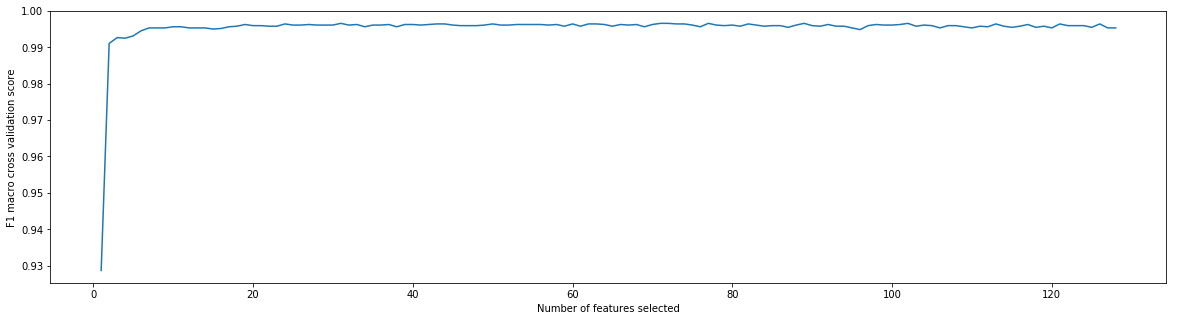

In [68]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("F1 macro cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

RFECV showed that 89 attributes can be useful for prediction. When looking at the plot above, we can see that approximately the same score can be achieved using less than 10 attributes!

Let's check, which features have been selected:

In [69]:
for i, x in enumerate(X_train_all.columns):
    if rfecv.support_[i]:
        print(x)

T4U
TT4
TSH
T3
FTI
age
capital-loss
capital-gain
fnlwgt
hours-per-week
education-num
origin_germany
origin_india
origin_jamaica
origin_mexico
origin_nicaragua
origin_united-states
query hyperthyroid_False
query hyperthyroid_True
query hypothyroid_False
query hypothyroid_True
on thyroxine_False
on thyroxine_True
tumor_False
tumor_True
sick_False
sick_True
thyroid surgery_False
thyroid surgery_True
workclass_ ?
workclass_ Federal-gov
workclass_ Local-gov
workclass_ Private
workclass_ Self-emp-inc
workclass_ Self-emp-not-inc
workclass_ State-gov
I131 treatment_False
I131 treatment_True
goitre_False
goitre_True
query on thyroxine_False
query on thyroxine_True
referral source_STMW
referral source_SVHC
referral source_SVHD
referral source_SVI
referral source_other
on antithyroid medication_False
on antithyroid medication_True
psych_False
psych_True
occupation_ Adm-clerical
occupation_ Craft-repair
occupation_ Exec-managerial
occupation_ Farming-fishing
occupation_ Handlers-cleaners
occupatio

For comparison, our classifiers trained on all attributes will be tried with reduced number of attributes:

In [70]:
X_train_new_rf = rfecv.transform(X_train_all_res)
X_train_new_dt = rfecv.transform(X_train_all)

X_test_new_dt = rfecv.transform(X_test_all)

Let's predict values and evaluate how well they performed:

In [71]:
dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=0)
dt.fit(X_train_new_dt, y_train)
print(classification_report(y_test, dt.predict(X_test_new_dt)))

                           precision    recall  f1-score   support

decreased binding protein       0.18      0.40      0.25         5
increased binding protein       0.35      0.68      0.47        25
                 negative       0.99      0.96      0.97       942

                micro avg       0.95      0.95      0.95       972
                macro avg       0.51      0.68      0.56       972
             weighted avg       0.97      0.95      0.96       972



In [72]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0, class_weight='balanced')
rf.fit(X_train_new_rf, y_all_res)
print(classification_report(y_test, rf.predict(X_test_new_dt)))

                           precision    recall  f1-score   support

decreased binding protein       1.00      0.20      0.33         5
increased binding protein       0.42      0.64      0.51        25
                 negative       0.99      0.98      0.98       942

                micro avg       0.96      0.96      0.96       972
                macro avg       0.80      0.61      0.61       972
             weighted avg       0.97      0.96      0.97       972



In case of RandomForest, score is significantly better with reduced number of attributes. On the other hand, DecisionTree performed similarly in both cases.

### Hyperparameter tuning

To improve performance of our models, we've done hyperparameter tuning using RandomizedSearchCV. As scoring metric we have chosen *f1 macro* and 10-fold cross-validation. For each classifier, typical hyperparameters have been tuned.

#### DecisionTree

For DecisionTree, parameters we've tuned parameters already mentioned before:

In [73]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)

param_dist = {
    "max_depth": [x for x in range(1, 15)], 
    "min_samples_leaf": [x for x in range(1, 6)], 
    "min_samples_split": [x for x in range(2, 6)], 
    "max_features": [x for x in range(1, 10)], 
    "criterion":["gini","entropy"]
}
tuned_dt = RandomizedSearchCV(dt, param_distributions=param_dist, cv=10, scoring='f1_macro')

In [74]:
tuned_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'min_samples_leaf': [1, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_macro', verbose=0)

What is the best configuration for DecisionTree?

In [75]:
tuned_dt.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=11, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

As we can see, several parameters have been chosen differently with RandomizedSearch parameter optimization. Let's check if this model performs better:

In [76]:
y_pred = tuned_dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

Accuracy:  0.9506172839506173 

                           precision    recall  f1-score   support

decreased binding protein       0.25      0.40      0.31         5
increased binding protein       0.36      0.72      0.48        25
                 negative       0.99      0.96      0.97       942

                micro avg       0.95      0.95      0.95       972
                macro avg       0.53      0.69      0.59       972
             weighted avg       0.97      0.95      0.96       972



After using best parameters for DecisionTree and predicting on fitted model, F1 macro score is slightly worse than before. It can be caused by the fact that parameter optimization was done with cross-validation on training data only, or just not choosing the best parameters using RandomizeSearch.

#### RandomForest

Hyperparameter optimization was done also for RandomForest. Because other parameters have been tried manually by choosing some configurations, only some of them were tuned.

In [77]:
rf = RandomForestClassifier(random_state=0, class_weight='balanced')

tuned_rf = RandomizedSearchCV(rf, param_distributions={'n_estimators': [x for x in range(10, 500, 20)], 'max_depth': [x for x in range(8, 20, 2)]}, cv=10, scoring='f1_macro')

In [78]:
tuned_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490], 'max_depth': [8, 10, 12, 14, 16, 18]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_macro', verbose=0)

In [79]:
tuned_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=410, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Let's check if this model performs any better:

In [80]:
y_pred = tuned_rf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

Accuracy:  0.9650205761316872 

                           precision    recall  f1-score   support

decreased binding protein       1.00      0.40      0.57         5
increased binding protein       0.43      0.80      0.56        25
                 negative       0.99      0.97      0.98       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.81      0.72      0.71       972
             weighted avg       0.98      0.97      0.97       972



In case of RandomForest, score is approximately the same. This can be caused by tuning parameters manually before.

### Conclusion and algorithms comparison

For classification of patients to 3 classes of their thyroid status, we have tried several classifiers and configurations.

**We have checked out 3 classifiers based on manually chosen rules:**
* using T4U attribute
* using T3 attribute
* combination of T4U, T3, TT4 and TSH attributes

From those classifiers, the one using T4U performed the best (the highest precision, recall and f1 score across classes in general).


**We have tried also 3 machine learning algorithms:**
* DecisionTree
* RandomForest
* XGBoost

XGBoost performed the best. In comparison to classifiers based on manually chosen rules, all of those machine learning classifiers performed better. Some parts of score (precision, recall, f1-score) could be worse in machine learning algorithms than in manually based algorithms, but in general were predicting better. Very high recall was achieved on class *decreased binding protein*, that was 100%. None of RandomForest or DecisionTree overcame this score, except XGBoost which is clearly the best choice.

**DecisionTree and RandomForest classifiers have been used for comparison of:**
* *training with all features* - this was shown to be bad choice at all
* *feature selection* - using RFECV, we were able to achieve comparative score with just a fraction of features, but in the end, our first choice of attributes based on analysis was significantly the best
* *different approaches of filling missing values* - we have found out that choice of filling missing values approach has just a small impact on achieved score, but we consider model filling as better

## Different filling methods comparison

Two approaches of filling nan values methods have been implemented. Maybe filling nan values can also influence the result. Whole classification above was done using model filling method (LinearRegression for numerical attributes, RandomForestClassifier for categorical attributes). Now, let's try filling nan values with median and most frequent values. Also let's compare both methods aftewards:

In [81]:
ppl_fill = Pipeline([
                # Data repairing
                # ======================
                # unify boolean values
                ('unify_boolean', BooleanUnifier(['query hyperthyroid', 'T4U measured', 'on thyroxine', 'FTI measured', 'lithium', 'TT4 measured',
                                                  'query hypothyroid', 'query on thyroxine', 'tumor', 'T3 measured', 'sick', 'thyroid surgery', 
                                                  'I131 treatment', 'goitre', 'TSH measured', 'on antithyroid medication', 'psych', 'TBG measured',
                                                  'pregnant', 'hypopituitary'])),

                # unify date format
                ('date_unifier', DateFormatUnifier('date_of_birth')),

                # drop column
                ('drop_TBG_measured', DropColumn('TBG measured')),
                ('drop_TBG', DropColumn('TBG')),

                # measured columns fix
                ('fix_measured_values',MeasuredValuesFixer(['T4U', 'FTI', 'TT4', 'TT4','TSH','T3'])),

                # expand column
                ('expand_personal_info', ColumnExpander()),

                # unify nan values
                ('nan_unify_FTI', NanUnifier(['FTI', 'sex', 'origin', 'occupation'])),

                # transform data type
                ('column_to_number_FTI', ColumnToNumber('FTI')),

                # merge and remove duplicates
                ('rm_duplicates', MergeRemoveDuplicates()),
                
                # ======================

                # Data normalization
                # ======================
                ('norm_numerical', Normalizer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Outliers replacement
                # ======================
                ('reout_numerical', OutliersReplacer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Filling numerical values with median
                # ======================
                ('fill_med', NumMedianFiller(['T4U', 'TT4', 'T3', 'TSH', 'FTI', 'age', 'education-num',
                                              'fnlwgt', 'capital-loss', 'capital-gain', 'hours-per-week'])),
                # ======================

                # Filling categorical with most frequent value
                # ======================
                ('fill_mf', CategoricalMostFrequentFiller(['sex', 'pregnant', 'tumor', 'occupation', 'origin',
                                                            'query hypothyroid', 'query hyperthyroid', 'on thyroxine',
                                                            'sick', 'thyroid surgery', 'workclass',
                                                            'I131 treatment', 'hypopituitary', 'query on thyroxine',
                                                            'on antithyroid medication', 'referral source', 'psych',
                                                            'date_of_birth', 'study', 'status1', 'status2'
                ]))
              ])

In [82]:
df_train_f = ppl_fill.fit_transform(df_train_raw)
df_valid_f = ppl_fill.transform(df_valid_raw)

df_train_f = ppl_class_unifier.fit_transform(df_train_f)
df_valid_f = ppl_class_unifier.transform(df_valid_f)

As in previous cases, we will just choose and encode the same attributes for exact comparison:

In [83]:
X_train_f = ppl_select_encode.fit_transform(df_train_f)
X_test_f = ppl_select_encode.transform(df_valid_f)

For comparison, again DecisionTree and RandomForest will be trained:

In [84]:
dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced')

In [85]:
dt.fit(X_train_f, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Let's check how model performed:

In [86]:
y_pred = dt.predict(X_test_f)
print("Accuracy: ", accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

Accuracy:  0.9639917695473251 

                           precision    recall  f1-score   support

decreased binding protein       0.60      0.60      0.60         5
increased binding protein       0.44      0.84      0.58        25
                 negative       0.99      0.97      0.98       942

                micro avg       0.96      0.96      0.96       972
                macro avg       0.68      0.80      0.72       972
             weighted avg       0.98      0.96      0.97       972



DecisionTree classifier, trained on dataset with missing values filled by most frequent value and median performed approximately the same as when filling missing values with model. Let's do the same with RandomForest classifier:

In [87]:
X_train_f_res, y_train_f_res = RandomOverSampler(random_state=0).fit_resample(X_train_f, y_train)

In [88]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0, class_weight='balanced')

In [89]:
rf.fit(X_train_f_res, y_train_f_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Let's check how model performed:

In [90]:
y_pred = rf.predict(X_test_f)
print("Accuracy: ", accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

Accuracy:  0.9722222222222222 

                           precision    recall  f1-score   support

decreased binding protein       1.00      0.40      0.57         5
increased binding protein       0.51      0.76      0.61        25
                 negative       0.99      0.98      0.99       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.83      0.71      0.72       972
             weighted avg       0.98      0.97      0.97       972



As we can see, in both cases (RandomForest and DecisionTree), the score is very similar for both filling approaches. Probably, this is influenced by data values distribution. In many cases, the most frequent value was also predicted by model. The same situation was with numerical values and median. However, we believe that filling missing values using models is still more sensible and effective.

## Predictions on test dataset

For submitting our solution, predictions on test dataset should be done. Because we have 3 very well performing classifiers, 3 predictions are going to be created. Let's try all best classifiers with best configurations found in previous steps:

In [91]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0, class_weight='balanced')
rf.fit(X_res_rand, y_res_rand)
print(classification_report(y_test, rf.predict(X_test)))

                           precision    recall  f1-score   support

decreased binding protein       1.00      0.40      0.57         5
increased binding protein       0.45      0.68      0.54        25
                 negative       0.99      0.98      0.98       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.81      0.69      0.70       972
             weighted avg       0.97      0.97      0.97       972



In [92]:
dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=0)
dt.fit(X_res_rand, y_res_rand)
print(classification_report(y_test, dt.predict(X_test)))

                           precision    recall  f1-score   support

decreased binding protein       0.57      0.80      0.67         5
increased binding protein       0.31      0.68      0.43        25
                 negative       0.99      0.96      0.97       942

                micro avg       0.95      0.95      0.95       972
                macro avg       0.63      0.81      0.69       972
             weighted avg       0.97      0.95      0.96       972



In [93]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=8, min_child_weight=2, gamma=0.1)
xgb.fit(X_res_rand, y_res_rand)
print(classification_report(y_test, xgb.predict(X_test)))

                           precision    recall  f1-score   support

decreased binding protein       0.62      1.00      0.77         5
increased binding protein       0.46      0.72      0.56        25
                 negative       0.99      0.97      0.98       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.69      0.90      0.77       972
             weighted avg       0.98      0.97      0.97       972



All predictions will be stored in csv files:

In [94]:
predictions_rf = pd.DataFrame(rf.predict(X_test_final))
predictions_rf = predictions_rf.rename(index=str, columns={0: "Predicted"})
predictions_rf.to_csv('pred_rf.csv', index_label='Id')

In [95]:
predictions_dt = pd.DataFrame(dt.predict(X_test_final))
predictions_dt = predictions_dt.rename(index=str, columns={0: "Predicted"})
predictions_dt.to_csv('pred_dt.csv', index_label='Id')

In [96]:
predictions_xgb = pd.DataFrame(xgb.predict(X_test_final))
predictions_xgb = predictions_xgb.rename(index=str, columns={0: "Predicted"})
predictions_xgb.to_csv('pred_xgb.csv', index_label='Id')